# INIT

## Imports

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


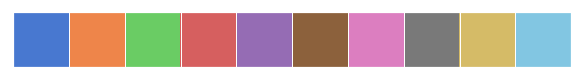

In [1]:
# Initializing

# general purpose
import pickle
import pandas as pd
import numpy as np
import scipy.stats as stats
import scipy

# plotting
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.pylab as mpl
import matplotlib.mlab as mlab
import matplotlib
import seaborn as sns
mpl.rcParams['font.family'] = 'DejaVu Sans'
sns.set(palette='muted')
default_palette = sns.color_palette()
sns.palplot(default_palette)

# display
from pprint import pprint
from IPython.display import display
from tqdm import tqdm_notebook

# sql related
import jaydebeapi

import os
import re
import copy
import glob
import json
import math
import itertools
from collections import namedtuple
import functools
import time
from pprint import pprint
from datetime import datetime
from datetime import timedelta

PROJECT_DIR = '/workspace/jupyter_notebooks/'
def get_path(path_str):
    return os.path.join(PROJECT_DIR, path_str)

## Convenience

In [2]:
def jointplot(
    x, y,
    x_bins=10, y_bins=10,
    alpha=1.0,
    side_alphas=(0.8, 0.8),
    histtype='step',
    linestyle='dashed',
    figsize=(8, 8),
):
    plt.figure(figsize=figsize)
    gs = plt.GridSpec(
        3, 3,
        wspace=0.1, hspace=0.1,
        width_ratios=[3, 3, 1], height_ratios=[1, 3, 3]
    )
    ax_main = plt.subplot(gs[1:, :-1])
    ax_top = plt.subplot(gs[0, :-1])
    ax_right = plt.subplot(gs[1:, -1])
    ax_main.scatter(x, y, alpha=alpha)
    ax_top.hist(x, bins=x_bins, alpha=side_alphas[0], histtype=histtype, linestyle=linestyle)
    ax_right.hist(y, bins=y_bins, alpha=side_alphas[1], orientation='horizontal', histtype=histtype, linestyle=linestyle)
    ax_main.set_xticks(np.linspace(ax_main.get_xbound()[0], ax_main.get_xbound()[1], len(ax_main.get_xticks())))
    ax_top.set_xticks(np.linspace(ax_main.get_xbound()[0], ax_main.get_xbound()[1], len(ax_main.get_xticks())))
    ax_top.set_xticklabels([])
    ax_top.yaxis.grid(False)
    
    ax_main.set_yticks(np.linspace(ax_main.get_ybound()[0], ax_main.get_ybound()[1], len(ax_main.get_yticks())))
    ax_right.set_yticks(np.linspace(ax_main.get_ybound()[0], ax_main.get_ybound()[1], len(ax_main.get_yticks())))
    ax_right.set_yticklabels([])
    ax_right.xaxis.grid(False)

In [3]:
def display_full(x):
    pd.set_option('display.max_rows', len(x))
    pd.set_option('display.max_colwidth', -1)
    display(x)
    pd.reset_option('display.max_rows')
    pd.reset_option('display.max_colwidth')

def widen_df(x):
    pd.set_option('display.max_colwidth', -1)
    display(x)
    pd.reset_option('display.max_colwidth')

In [4]:
from concurrent.futures import ProcessPoolExecutor
from functools import wraps


class Futurize:
    exec_pool = ProcessPoolExecutor()
    exec_jobs = {}
    
    def __init__(self, func):
        self._func = func
        self._func_name = func.__name__
        
    def __call__(self, *args, **kwargs):
        start_time = time.asctime(time.localtime())
        extra_type = kwargs.pop('extra_type', None)
        futured = self.exec_pool.submit(self._func, *args, **kwargs)
        type_str = '{} - {}'.format(self._func_name, extra_type) if extra_type else self._func_name
        self.exec_jobs[futured] = {
            'start_time': start_time,
            'type': type_str,
        }
        return futured
    
    @staticmethod
    def result(future_instance):
        try:
            result = future_instance.result()
        except:
            raise
        finally:
            del Futurize.exec_jobs[future_instance]
        return result


def query_as_df(sql):
    try:
        conn = jaydebeapi.connect(**conn_props)
    except:
        raise

    try:
        start_time = time.time()
        query_df = pd.read_sql_query(sql, conn)
        print("Time To Query: {:2.2f} sec".format(time.time()-start_time))
        return query_df
    except:
        raise
    finally:
        conn.close()

In [5]:
import multiprocessing as mp

def pandas_mp_apply(grouped_df, apply_func):
    with mp.Pool(mp.cpu_count()) as p:
        ret_list = p.map(apply_func, [group for name, group in grouped_df])
    return pd.concat(ret_list)

In [6]:
query_as_df_async = Futurize(query_as_df)
pandas_mp_apply_async = Futurize(pandas_mp_apply)

In [6]:
def date_range(start_time,end_time,hour_shift=0,table=None):
    #### function to get the date range string for SQL

    s = pd.to_datetime(start_time) - pd.Timedelta(hours = hour_shift)
    e = pd.to_datetime(end_time) - pd.Timedelta(hours = hour_shift)
    s_day =  datetime.datetime(year=s.year, month=s.month, day=s.day)
    e_day =  datetime.datetime(year=e.year, month=e.month, day=e.day)
    year_list = [s_day.year]
    month_list = [[s_day.month]]
    day_list = [[[]]]
    while s_day <= e_day:
        if s_day.year != year_list[-1]:
            year_list.append(s_day.year)
            month_list.append([s_day.month])
            day_list.append([[s_day.day]])
        elif s_day.month != month_list[-1][-1]:
            month_list[-1].append(s_day.month)
            day_list[-1].append([s_day.day])
        else:
            day_list[-1][-1].append(s_day.day)
        s_day += timedelta(days=1)


    if table is None or table == '' or len(table) == 0 or isinstance(table, list) == False:
        string = '('
    else:
        string = ['(']*len(table)
    for y in range(len(year_list)):
        for m in range(len(month_list[y])):
            min_day = day_list[y][m][0]
            max_day = day_list[y][m][-1]
            if table is None or table == '' or len(table) == 0 :
                string += "(year = \'%4d\' and month = \'%02d\' and day between \'%02d\' and \'%02d\')\n or " \
                    %(year_list[y], month_list[y][m], min_day,max_day)
            elif isinstance(table, list) == False:
                string += "(%s.year = \'%4d\' and %s.month = \'%02d\' and %s.day between \'%02d\' and \'%02d\')\n or " \
                        %(table,year_list[y], table, month_list[y][m], table, min_day,max_day)
            else:
                for i in range(len(string)):
                    if  table[i] is None or len(table[i]) == 0:
                        string[i] += "(year = \'%4d\' and month = \'%02d\' and day between \'%02d\' and \'%02d\')\n or " \
                            %(year_list[y], month_list[y][m], min_day,max_day)
                    else:
                        string[i] += "(%s.year = \'%4d\' and %s.month = \'%02d\' and %s.day between \'%02d\' and \'%02d\')\n or " \
                            %(table[i],year_list[y], table[i], month_list[y][m], table[i], min_day,max_day)
    if table is None or table == '' or len(table) == 0 or isinstance(table, list) == False:
        string = string[:-5]
        string += ')'
    else:
        for i in range(len(string)):
            string[i] = string[i][:-5]
            string[i] += ')'
    return string

## Spark UDFs

In [ ]:
def year_of_week(x):
    # weekday returns value between 0 to 6
    if isinstance(x, float) or isinstance(x, int):
        dt = datetime.datetime.fromtimestamp(x)
    if isinstance(x, str) or isinstance(x, str):
        dt = datetime.datetime.strptime(x, '%Y-%m-%d')
    if isinstance(x, datetime.date) or isinstance(x, datetime.datetime):
        dt = x
    monday = dt - datetime.timedelta(days=dt.weekday())
    return monday.year

spark.udf.register("yow", year_of_week)


def week(x):
    # weekday returns value between 0 to 6
    if isinstance(x, float) or isinstance(x, int):
        dt = datetime.datetime.fromtimestamp(x)
    if isinstance(x, str) or isinstance(x, str):
        dt = datetime.datetime.strptime(x, '%Y-%m-%d')
    if isinstance(x, datetime.date) or isinstance(x, datetime.datetime):
        dt = x
    return dt.isocalendar()[1]

spark.udf.register("week", week)


def day_of_week(x):
    # weekday returns value between 0 to 6
    if isinstance(x, float) or isinstance(x, int):
        dt = datetime.datetime.fromtimestamp(x)
    if isinstance(x, str) or isinstance(x, str):
        dt = datetime.datetime.strptime(x, '%Y-%m-%d')
    if isinstance(x, datetime.date) or isinstance(x, datetime.datetime):
        dt = x
    return dt.weekday()+1

spark.udf.register("dow", day_of_week)


def week_start(x):
    if isinstance(x, float) or isinstance(x, int):
        dt = datetime.datetime.fromtimestamp(x)
    elif isinstance(x, str) or isinstance(x, str):
        dt = datetime.datetime.strptime(x, '%Y-%m-%d')
    elif isinstance(x, datetime.date) or isinstance(x, datetime.datetime):
        dt = x
    else:
        # dangerous
        dt = x
    return str(dt - datetime.timedelta(days=dt.weekday()))
    
spark.udf.register('week_start', week_start)


def array_to_string(arr):
    return '[' + ','.join([str(element) for element in arr]) + ']'

spark.udf.register('array_to_string', array_to_string)

In [7]:
import dask
import dask.dataframe as dd

In [8]:
from dask.distributed import Client

client = Client('10.59.62.175:8786')
client

Client Scheduler: tcp://10.59.62.175:8786 Dashboard: http://10.59.62.175:8787/status,Cluster Workers: 20 Cores: 80 Memory: 639.74 GB


In [9]:
client.get_versions(check=True)

{'scheduler': {'host': (('python', '3.6.6.final.0'),
   ('python-bits', 64),
   ('OS', 'Linux'),
   ('OS-release', '3.10.0-693.5.2.el7.x86_64'),
   ('machine', 'x86_64'),
   ('processor', ''),
   ('byteorder', 'little'),
   ('LC_ALL', 'None'),
   ('LANG', 'C.UTF-8'),
   ('LOCALE', 'en_US.UTF-8')),
  'packages': {'required': (('dask', '0.18.2'),
    ('distributed', '1.22.1'),
    ('msgpack', '0.5.6'),
    ('cloudpickle', '0.5.3'),
    ('tornado', '5.1'),
    ('toolz', '0.9.0')),
   'optional': (('numpy', '1.15.0'),
    ('pandas', '0.23.4'),
    ('bokeh', '0.13.0'),
    ('lz4', None),
    ('blosc', None))}},
 'workers': {'tcp://10.59.40.62:12345': {'host': (('python', '3.6.6.final.0'),
    ('python-bits', 64),
    ('OS', 'Linux'),
    ('OS-release', '3.10.0-693.5.2.el7.x86_64'),
    ('machine', 'x86_64'),
    ('processor', ''),
    ('byteorder', 'little'),
    ('LC_ALL', 'None'),
    ('LANG', 'C.UTF-8'),
    ('LOCALE', 'en_US.UTF-8')),
   'packages': {'required': (('dask', '0.18.2'),
   

In [168]:
client.restart()

Client Scheduler: tcp://10.59.62.175:8786 Dashboard: http://10.59.62.175:8787/status,Cluster Workers: 10 Cores: 40 Memory: 319.92 GB
